<a href="https://colab.research.google.com/github/franmariG/mlp-clasificacion-setas/blob/main/Clasificaci%C3%B3n_de_Setas_(Comestible_vs_Venenosa)_MLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de Librerias



In [ ]:
# Se importan las librerías necesarias para el desarrollo del proyecto.

import pandas as pd  # Para la manipulación y análisis de datos en estructuras tipo DataFrame.
import numpy as np  # Para el manejo de arreglos y operaciones numéricas de bajo nivel.
from sklearn.model_selection import train_test_split  # Para dividir el dataset en conjuntos de entrenamiento y prueba.
from sklearn.preprocessing import LabelEncoder  # Para codificar los atributos categóricos en valores numéricos.
from sklearn.metrics import confusion_matrix, classification_report  # Para evaluar el desempeño del modelo mediante métricas y matriz de confusión.
import matplotlib.pyplot as plt  # Para la generación de gráficos y visualizaciones.
import seaborn as sns  # Para gráficos más estéticos y personalizados, como el mapa de calor de la matriz de confusión.

# Descarga automática del dataset desde Google Drive

In [ ]:
# Descarga automática del dataset desde Google Drive mediante gdown.
# El archivo descargado se guarda con el nombre 'mushrooms.csv'.
# Esto permite que el dataset esté disponible en el entorno de ejecución sin necesidad de cargarlo manualmente.

!gdown "https://drive.google.com/uc?id=1t5W53ml1KG5QSa4QY2JB9OtCKqEb_NCj" -O mushrooms.csv

Downloading...
From: https://drive.google.com/uc?id=1t5W53ml1KG5QSa4QY2JB9OtCKqEb_NCj
To: /content/mushrooms.csv
100% 374k/374k [00:00<00:00, 13.9MB/s]


# Preparación de los datos

In [ ]:
# En esta sección se realiza el preprocesamiento del dataset antes de entrenar el modelo.
# Esto incluye: carga del archivo, eliminación de columnas sin variabilidad, manejo de valores faltantes
# y codificación de los atributos categóricos en valores numéricos. Finalmente, se separan las variables predictoras
# y la clase objetivo, y se divide el dataset en conjuntos de entrenamiento y prueba.

# Cargar el dataset
df = pd.read_csv("mushrooms.csv")

# Eliminar columna sin variación
if 'veil-type' in df.columns:
    df = df.drop(columns=['veil-type'])

# Reemplazar posibles valores faltantes ('?') por NaN y luego eliminar esas filas
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

# Codificar todas las columnas categóricas a números
label_encoders = {}
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Guardamos por si se necesita decodificar luego

# Separar características (X) y clase (y)
X = df.drop(columns=['class']).values
y = df['class'].values.reshape(-1, 1)

# Dividir en entrenamiento y prueba (60% - 40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Mostrar tamaños
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (3386, 21)
Tamaño del conjunto de prueba: (2258, 21)


# Construcción del Modelo MLP

In [ ]:
# En esta sección se definen las funciones de activación y la clase que representa el Perceptrón Multicapa (MLP).

# Función de activación sigmoide: se usa en la capa de salida para producir valores entre 0 y 1 (probabilidades).
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivada de la función sigmoide: necesaria para el cálculo del gradiente durante la retropropagación.
def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

# Función de activación ReLU: se usa en la capa oculta para introducir no linealidad y mejorar el aprendizaje.
def relu(x):
    return np.maximum(0, x)

# Derivada de la función ReLU: se utiliza en la retropropagación para actualizar los pesos de la capa oculta.
def relu_deriv(x):
    return (x > 0).astype(float)

# Clase MLP: define la arquitectura y los métodos de entrenamiento y predicción del Perceptrón Multicapa.
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        self.lr = learning_rate  # Tasa de aprendizaje
        self.losses = []  # Registro de la pérdida en cada época
        self.accuracies = []  # Registro de la precisión en cada época

        # Inicialización de los pesos y sesgos para la capa de entrada a oculta
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))

        # Inicialización de los pesos y sesgos para la capa oculta a salida
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    # Propagación hacia adelante: calcula las salidas de cada capa.
    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = relu(self.z1)

        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)

        return self.a2

    # Retropropagación: actualiza los pesos y sesgos para minimizar la pérdida.
    def backpropagate(self, X, y, output):
        error = output - y
        d_output = error * sigmoid_deriv(self.z2)

        d_hidden = np.dot(d_output, self.W2.T) * relu_deriv(self.z1)

        self.W2 -= self.lr * np.dot(self.a1.T, d_output)
        self.b2 -= self.lr * np.sum(d_output, axis=0, keepdims=True)

        self.W1 -= self.lr * np.dot(X.T, d_hidden)
        self.b1 -= self.lr * np.sum(d_hidden, axis=0, keepdims=True)

    # Método de entrenamiento: ejecuta el proceso de forward y backpropagation durante el número de épocas definido.
    def train(self, X, y, epochs=100):
        for epoch in range(epochs):
            output = self.forward(X)
            self.backpropagate(X, y, output)
            loss = np.mean((y - output) ** 2)
            self.losses.append(loss)

            predictions = (output > 0.5).astype(int)
            accuracy = np.mean(predictions == y)
            self.accuracies.append(accuracy)

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    # Método predict: realiza una predicción binaria en base al umbral de 0.5.
    def predict(self, X):
        output = self.forward(X)
        return (output > 0.5).astype(int)

    # Método evaluate: calcula la precisión sobre un conjunto de datos dado.
    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy

# Entrenamiento del modelo

In [ ]:
# Entrenamiento del modelo
# Se crea una instancia del Perceptrón Multicapa (MLP) con:
# - 21 neuronas en la capa de entrada (una por cada atributo predictivo)
# - 30 neuronas en la capa oculta (ajustadas tras pruebas para mejorar el rendimiento)
# - 1 neurona en la capa de salida (para clasificación binaria)
# - Tasa de aprendizaje de 0.001 (elegida para un aprendizaje más estable)
# El modelo se entrena durante 1000 épocas para permitir la convergencia de la pérdida.

model = MLP(input_size=21, hidden_size=30, output_size=1, learning_rate=0.001)
model.train(X_train, y_train, epochs=1000)

Epoch 10, Loss: 0.2369
Epoch 20, Loss: 0.2679
Epoch 30, Loss: 0.1922
Epoch 40, Loss: 0.1426
Epoch 50, Loss: 0.1263
Epoch 60, Loss: 0.1013
Epoch 70, Loss: 0.0932
Epoch 80, Loss: 0.0960
Epoch 90, Loss: 0.0865
Epoch 100, Loss: 0.0851
Epoch 110, Loss: 0.0803
Epoch 120, Loss: 0.0773
Epoch 130, Loss: 0.0744
Epoch 140, Loss: 0.0732
Epoch 150, Loss: 0.0714
Epoch 160, Loss: 0.0697
Epoch 170, Loss: 0.0683
Epoch 180, Loss: 0.0746
Epoch 190, Loss: 0.0590
Epoch 200, Loss: 0.0605
Epoch 210, Loss: 0.0561
Epoch 220, Loss: 0.0493
Epoch 230, Loss: 0.1003
Epoch 240, Loss: 0.0398
Epoch 250, Loss: 0.0670
Epoch 260, Loss: 0.0402
Epoch 270, Loss: 0.0407
Epoch 280, Loss: 0.0521
Epoch 290, Loss: 0.0711
Epoch 300, Loss: 0.0519
Epoch 310, Loss: 0.0308
Epoch 320, Loss: 0.0413
Epoch 330, Loss: 0.0278
Epoch 340, Loss: 0.0235
Epoch 350, Loss: 0.0248
Epoch 360, Loss: 0.0190
Epoch 370, Loss: 0.0279
Epoch 380, Loss: 0.0176
Epoch 390, Loss: 0.0151
Epoch 400, Loss: 0.0287
Epoch 410, Loss: 0.0186
Epoch 420, Loss: 0.0144
E

# Evaluación del Modelo




## Precisión del Modelo

In [ ]:
# Se calcula la precisión (accuracy) del modelo sobre los conjuntos de entrenamiento y prueba.
# Esto permite evaluar qué tan bien generaliza el modelo a datos no vistos.

train_acc = model.evaluate(X_train, y_train)
test_acc = model.evaluate(X_test, y_test)

print(f"Precisión en entrenamiento: {train_acc * 100:.2f}%")
print(f"Precisión en prueba: {test_acc * 100:.2f}%")

Precisión en entrenamiento: 99.20%
Precisión en prueba: 99.60%


## Matriz de confusión



In [ ]:
# Se generan las predicciones del modelo sobre el conjunto de prueba.
# La matriz de confusión permite visualizar cuántas instancias fueron clasificadas correctamente o incorrectamente.

y_pred = model.predict(X_test)

# La matriz espera vectores 1D, por eso se usa ravel() para aplanar las etiquetas reales y predichas.
cm = confusion_matrix(y_test.ravel(), y_pred.ravel())

print("Matriz de confusión:")
print(cm)

Matriz de confusión:
[[1403    0]
 [   9  846]]


## Reporte de clasificación

In [ ]:
# Se genera el reporte de clasificación que incluye las métricas de precisión, recall y f1-score para cada clase.
# Esto permite un análisis más detallado del rendimiento por categoría.

target_names = label_encoders['class'].classes_
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=["comestible", "venenosa"]))

Reporte de clasificación:
              precision    recall  f1-score   support

  comestible       0.99      1.00      1.00      1403
    venenosa       1.00      0.99      0.99       855

    accuracy                           1.00      2258
   macro avg       1.00      0.99      1.00      2258
weighted avg       1.00      1.00      1.00      2258



# Validación del modelo con instancias artificiales y reales

In [ ]:
# En esta sección se crean ejemplos manuales de setas para probar la capacidad del modelo para predecir nuevas instancias.

# Ejemplo de una seta artificial con características típicas de una venenosa
seta_nueva_venenosa = {
    'cap-shape': 'x',  # convex
    'cap-surface': 'y',  # scaly
    'cap-color': 'e',  # red
    'bruises': 'f',  # no bruises
    'odor': 'f',  # foul (típico de setas venenosas en el dataset)
    'gill-attachment': 'f',  # free
    'gill-spacing': 'c',  # close
    'gill-size': 'n',  # narrow
    'gill-color': 'r',  # black
    'stalk-shape': 'e',  # enlarging
    'stalk-root': 'b',  # bulbous
    'stalk-surface-above-ring': 's',  # smooth
    'stalk-surface-below-ring': 's',
    'stalk-color-above-ring': 'w',
    'stalk-color-below-ring': 'w',
    'veil-color': 'w',
    'ring-number': 'o',  # one
    'ring-type': 'p',  # pendant
    'spore-print-color': 'k',  # black
    'population': 'v',
    'habitat': 'u'  # urban
}

# Ejemplo de una seta artificial con características típicas de una comestible
seta_nueva_comestible = {
    'cap-shape': 'x',
    'cap-surface': 's',  # smooth
    'cap-color': 'n',  # brown
    'bruises': 't',  # bruises
    'odor': 'a',  # almond (típico de setas comestibles)
    'gill-attachment': 'f',
    'gill-spacing': 'w',  # crowded
    'gill-size': 'b',  # broad
    'gill-color': 'n',
    'stalk-shape': 'e',
    'stalk-root': 'b',
    'stalk-surface-above-ring': 's',
    'stalk-surface-below-ring': 's',
    'stalk-color-above-ring': 'w',
    'stalk-color-below-ring': 'w',
    'veil-color': 'w',
    'ring-number': 'o',
    'ring-type': 'p',
    'spore-print-color': 'w',
    'population': 'v',
    'habitat': 'g'  # grasses
}

# Ejemplo de una seta inspirada en la Gyromitra esculenta
seta_gyromitra = {
    'cap-shape': 'b',
    'cap-surface': 'y',
    'cap-color': 'e',
    'bruises': 'f',
    'odor': 'n',  # se puede modificar a 'f' para observar el efecto
    'gill-attachment': 'f',
    'gill-spacing': 'c',
    'gill-size': 'n',
    'gill-color': 'k',
    'stalk-shape': 'e',
    'stalk-root': 'b',
    'stalk-surface-above-ring': 'y',
    'stalk-surface-below-ring': 'y',
    'stalk-color-above-ring': 'n',
    'stalk-color-below-ring': 'n',
    'veil-color': 'w',
    'ring-number': 'n',
    'ring-type': 'e',
    'spore-print-color': 'k',
    'population': 'y',
    'habitat': 'd'
}

# Codificación y predicción para la seta Gyromitra
valores_codificados = []

# Si se desea probar otra seta (por ejemplo, 'seta_nueva_comestible' o 'seta_nueva_venenosa'),
# basta con cambiar 'seta_gyromitra.items()' por el diccionario correspondiente, por ejemplo:
# for feature, valor in seta_nueva_comestible.items():
for feature, valor in seta_gyromitra.items():
    valor_cod = label_encoders[feature].transform([valor])[0]
    valores_codificados.append(valor_cod)

entrada = np.array(valores_codificados).reshape(1, -1)
pred = model.predict(entrada)

# Interpretación del resultado
print("Resultado:", "venenosa" if pred[0][0] == 1 else "comestible")

Resultado: comestible


# Visualización de resultados

Las gráficas se generaron para exportarlas e incluirlas como figuras en el paper, donde son analizadas.


## Matriz de confusión (visualización)



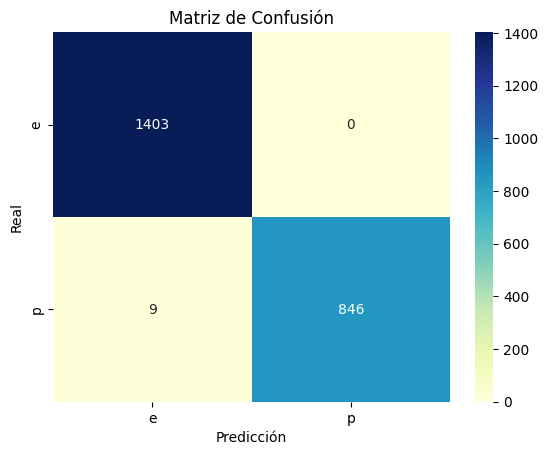

In [ ]:
# Gráfica de la matriz de confusión.
# Permite visualizar de forma clara el desempeño del modelo, mostrando las predicciones correctas e incorrectas.
# Los ejes muestran las clases reales y predichas, y los colores indican la frecuencia de cada combinación.

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

## Curva de pérdida del entrenamiento

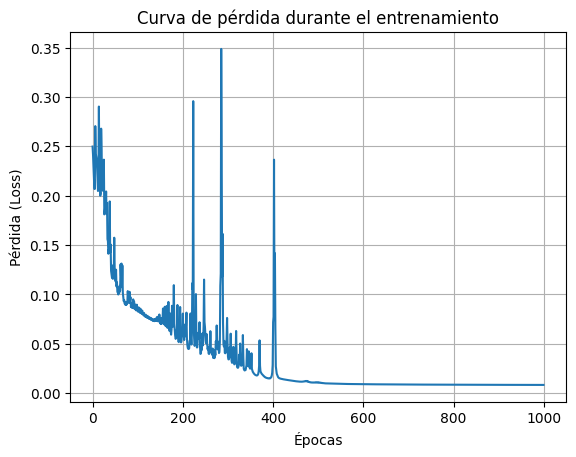

In [ ]:
# Gráfica de la curva de pérdida durante el entrenamiento.
# Muestra cómo la función de pérdida (error cuadrático medio) disminuye a lo largo de las épocas,
# lo que permite analizar el proceso de aprendizaje del modelo.

plt.plot(model.losses)
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Curva de pérdida durante el entrenamiento")
plt.grid(True)
plt.show()

## Curva de precisión durante el entrenamiento

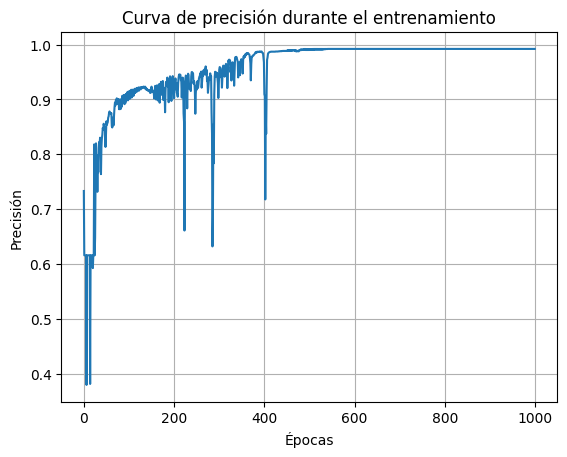

In [ ]:
# Gráfica de la curva de precisión durante el entrenamiento.
# Permite observar cómo la precisión del modelo evoluciona con el número de épocas,
# identificando posibles signos de sobreajuste o estancamiento.

plt.plot(model.accuracies)
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Curva de precisión durante el entrenamiento")
plt.grid(True)
plt.show()